In [2]:
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import json
import sys
from scipy import stats

%matplotlib inline

In [3]:
matchup_df = pd.read_csv("temp_matchupdf.csv")

In [4]:
matchup_df.columns

Index([u'AB', u'H', u'PA', u'RL', u'SAC', u'SO', u'TB', u'W', u'bID', u'pID',
       u'AVG', u'OBP', u'ov_AVG', u'ov_OBP', u'ov_PA', u'ov_AB', u'ov_H',
       u'ov_W', u'ov_TB', u'ov_SAC', u'ovp_SO_PCT', u'ovp_W_PCT', u'ovp_H_PCT',
       u'ovp_SAC', u'ovp_SO', u'ovp_AB', u'ovp_H', u'ovp_W', u'opv_TB',
       u'ovp_PA'],
      dtype='object')

In [6]:
dftouse=matchup_df.copy()

In [7]:
dftouse.head()

,AB,H,PA,RL,SAC,SO,TB,W,bID,pID,...,ovp_SO_PCT,ovp_W_PCT,ovp_H_PCT,ovp_SAC,ovp_SO,ovp_AB,ovp_H,ovp_W,opv_TB,ovp_PA
0,5,1,5,R,0,2,1,0,torrc001,medlk001,...,0.197736,0.064581,0.237683,13,297,1405,357,97,674,1502
1,3,0,3,L,1,2,0,0,kinnm002,leita001,...,0.177112,0.131925,0.218144,91,1023,5014,1260,762,2335,5776
2,4,1,4,R,0,2,1,0,valee002,ayall001,...,0.145196,0.092527,0.252669,29,204,1275,355,130,611,1405
3,7,0,7,R,0,4,0,0,valee002,beckj002,...,0.215781,0.088328,0.225465,79,1649,6967,1723,675,3437,7642
4,3,2,6,R,0,0,2,3,valee002,bumpn001,...,0.122744,0.115523,0.234657,2,34,245,65,32,109,277


In [8]:
dftouse.dtypes

AB              int64
H               int64
PA              int64
RL             object
SAC             int64
SO              int64
TB              int64
W               int64
bID            object
pID            object
AVG           float64
OBP           float64
ov_AVG        float64
ov_OBP        float64
ov_PA           int64
ov_AB           int64
ov_H            int64
ov_W            int64
ov_TB           int64
ov_SAC          int64
ovp_SO_PCT    float64
ovp_W_PCT     float64
ovp_H_PCT     float64
ovp_SAC         int64
ovp_SO          int64
ovp_AB          int64
ovp_H           int64
ovp_W           int64
opv_TB          int64
ovp_PA          int64
dtype: object

In [42]:
def compute_supports(df):
    ubids=df.bID.unique()
    pitch = df.groupby('pID').bID.unique()
    bdict={}
    for e,v in zip(pitch.index.values, pitch.values):
        bdict[e] = np.array([item in v for item in ubids])
    pitchers=bdict.keys()
    supports=[]
    for i,p1 in enumerate(pitchers):
        for j,p2 in enumerate(pitchers):
            if  i < j:
                supmask = (bdict[p1] & bdict[p2])
                common_batters = np.sum(supmask)
                supports.append(common_batters)
    print "mean support",np.mean(supports), "median support", np.median(supports)
    return supports, bdict

In [99]:
def recompute_frame(ldf):
    """
    takes a dataframe ldf, makes a copy of it, and returns the copy
    with all averages and review counts recomputed
    this is used when a frame is subsetted.
    """
    ldfb=ldf.groupby('bID')
    ldfp=ldf.groupby('pID')
    batter_avg=ldfb.AVG.mean()
    batter_PA_count=ldfb.RL.count()
    pitcher_avg=ldfp.AVG.mean()
    pitcher_PA_count=ldfp.RL.count()
    nldf=ldf.copy()
    nldf.set_index(['pID'], inplace=True)
    nldf['pitcher_avg']=pitcher_avg
    nldf['pitcher_PA_count']=pitcher_PA_count
    nldf.reset_index(inplace=True)
    nldf.set_index(['bID'], inplace=True)
    nldf['batter_avg']=batter_avg
    nldf['batter_PA_count']=batter_PA_count
    nldf.reset_index(inplace=True)
    return nldf

In [101]:
def make_smaller(df, pacountp, pacountb):
    smallidf1=df[(df.ovp_PA > pacountp)]
    smallidf1=recompute_frame(smallidf1)
    smallidf2=smallidf1[(smallidf1.ov_PA > pacountb)]
    smalldf=recompute_frame(smallidf2)
    return smalldf

In [104]:
smalldf=make_smaller(dftouse, 100, 100)
smalldf.to_csv("small.csv", index=False)
print "Number of Matchups",smalldf.shape[0]
print "Number of Batters", smalldf.bID.unique().shape[0]
print "Number of Pitchers", smalldf.pID.unique().shape[0]
s,d=compute_supports(smalldf)

Number of Matchups 237938
Number of Batters 1180
Number of Pitchers 1707
mean support 28.6896923296 median support 13.0


Batter avgs mean and median 201.642372881 150.0


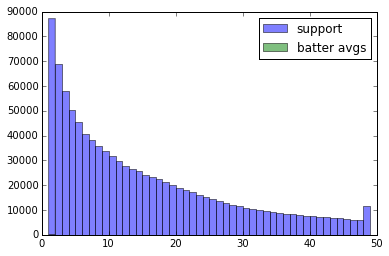

In [105]:
plt.hist(s, bins=np.arange(1,50,1), alpha=0.5, label="support");
c=smalldf.groupby('bID').pID.count()
print "Batter avgs mean and median",np.mean(c), np.median(c)
plt.hist(c, bins=np.arange(1,50,1), alpha=0.5, label="batter avgs");
plt.legend();
plt.show()

In [107]:
print smalldf.shape
smalldf=smalldf.drop_duplicates(['bID','pID'])
print smalldf.shape
#smalldf.dtypes
smalldf.head(50)

(237938, 34)
(237938, 34)


,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_SO,ovp_AB,ovp_H,ovp_W,opv_TB,ovp_PA,pitcher_avg,pitcher_PA_count,batter_avg,batter_PA_count
0,valee002,ayall001,4,1,4,R,0,2,1,0,...,204,1275,355,130,611,1405,0.280574,220,0.218245,32
1,valee002,beckj002,7,0,7,R,0,4,0,0,...,1649,6967,1723,675,3437,7642,0.242067,537,0.218245,32
2,valee002,bumpn001,3,2,6,R,0,0,2,3,...,34,245,65,32,109,277,0.264037,52,0.218245,32
3,valee002,burna001,4,0,4,R,0,3,0,0,...,2045,8536,2134,1075,4082,9611,0.243713,644,0.218245,32
4,valee002,byrdp001,4,1,4,R,0,1,5,0,...,676,5358,1547,357,3117,5715,0.296668,419,0.218245,32
5,valee002,clemr001,6,0,6,R,0,3,0,0,...,1823,7367,1749,777,3299,8144,0.227873,409,0.218245,32
6,valee002,cordc001,4,1,5,R,0,1,1,1,...,175,776,179,97,376,873,0.220149,136,0.218245,32
7,valee002,daigc001,3,2,5,R,0,0,4,2,...,11,110,30,11,60,121,0.293939,22,0.218245,32
8,valee002,foggj001,5,2,5,R,0,2,2,0,...,512,3863,1145,459,2373,4322,0.282621,364,0.218245,32
9,valee002,greiz001,4,1,4,R,0,0,1,0,...,1477,6506,1671,496,3161,7002,0.252587,530,0.218245,32


#Splitting into Test and Training Sets

In [108]:
print smalldf.shape,
smalldf[smalldf.batter_PA_count > 150].shape

(237938, 34)

(214102, 34)

In [109]:
trainlist=[]
testlist=[]
validatelist=[]
take=5
for k, v in smalldf.groupby('bID'):
    if np.mean(v.batter_PA_count) > 150:
        takenos=np.random.choice(range(take), size=take/2, replace=False)
        takelist=np.array([e in takenos for e in range(take)])
        validatelist.append(v[-take:][~takelist])#use those 
        testlist.append(v[-take:][takelist])#use the other 
        trainlist.append(v[:-take])
    else:
        trainlist.append(v)
traindf=pd.concat(trainlist)
validatedf=pd.concat(validatelist)
testdf=pd.concat(testlist)
print traindf.shape, validatedf.shape, testdf.shape

(235033, 34) (1743, 34) (1162, 34)


In [110]:

maskval=[e in set(validatedf.pID).difference(set(traindf.pID)) for e in validatedf.pID] 
masktest=[e in set(testdf.pID).difference(set(traindf.pID)) for e in testdf.pID] 
print np.sum(maskval), np.sum(masktest)

0 0


In [111]:
traindf=recompute_frame(traindf)
validatedf=recompute_frame(validatedf)
testdf=recompute_frame(testdf)
validatedf=validatedf[['bID', 'pID','AVG']]
testdf=testdf[['bID', 'pID', 'AVG']]
traindf.head()

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_SO,ovp_AB,ovp_H,ovp_W,opv_TB,ovp_PA,pitcher_avg,pitcher_PA_count,batter_avg,batter_PA_count
0,aberb001,armat002,4,1,4,R,0,1,1,0,...,493,2714,724,404,1512,3118,0.257677,286,0.240567,85
1,aberb001,baldj002,6,2,6,R,0,0,6,0,...,469,3019,853,324,1733,3343,0.287744,239,0.240567,85
2,aberb001,bauer001,4,0,4,R,0,0,0,0,...,95,718,205,92,372,810,0.289811,118,0.240567,85
3,aberb001,bellr003,9,1,10,R,0,0,1,1,...,288,2007,595,242,1355,2249,0.285844,234,0.240567,85
4,aberb001,benoj001,4,1,5,R,0,0,1,1,...,617,2604,629,348,1293,2952,0.238144,326,0.240567,85


#The baseline model

In [214]:
ybar = traindf.AVG.mean()
ybar

0.2651000110624007

In [215]:
ubids=traindf.bID.unique()#unique-user-ids
upids=traindf.pID.unique()#unique-item-ids
print ubids,upids,len(upids),len(ubids)


['aberb001' 'aberr001' 'abreb001' ..., 'zitob001' 'zobrb001' 'zunim001'] ['armat002' 'baldj002' 'bauer001' ..., 'zerbc001' 'younc001' 'younm001'] 1707 1180


In [216]:
ubidmap={v:k for k,v in enumerate(ubids)}#of length U
upidmap={v:k for k,v in enumerate(upids)}#of length M

In [217]:
bate='blazr001'
traindf[traindf.bID==bate]

,bID,pID,AB,H,PA,RL,SAC,SO,TB,W,...,ovp_SO,ovp_AB,ovp_H,ovp_W,opv_TB,ovp_PA,pitcher_avg,pitcher_PA_count,batter_avg,batter_PA_count


In [221]:
batter_biases={}
pitcher_biases={}

for uindx, batter in enumerate(ubids):
    batter_row=traindf[traindf.bID==batter]
    yb=batter_row.batter_avg.unique()[0]
    bbaseline = yb - ybar
    batter_biases[batter]=bbaseline

for iindx, pit in enumerate(upids):
    pit_row=traindf[traindf.pID==pit]
    yp=pit_row.pitcher_avg.unique()[0]
    pbaseline = yp - ybar
    pitcher_biases[pit]=pbaseline

In [222]:
pitcher_biases

{'torrc001': 0.0072306476967706756,
 'kinnm002': 0.009268391003330545,
 'florr001': 0.020380654105746909,
 'basta001': -0.052598371288048507,
 'mussm001': -0.0064414245628571232,
 'schic002': -0.022744604571799443,
 'coggd001': 0.026054298762738459,
 'harrp001': 0.002059266441668206,
 'kuo-h001': -0.049068892422617277,
 'nealb001': 0.063389315702806148,
 'willj003': -0.0035407751911012419,
 'wagnr001': 0.037910424556700517,
 'stepg001': -0.010767436146666309,
 'wilsj004': -0.048319965710972135,
 'clarm002': 0.027037284030143827,
 'davet001': 0.055270359307932615,
 'rilem001': -0.053680257975993323,
 'jimeu001': -0.018475712186668158,
 'johnj010': 0.014795036329256717,
 'manzj001': -0.026115731453121988,
 'osorf001': 0.06281281685044543,
 'gregk001': -0.025755179698525033,
 'eovan001': 0.017907509568064528,
 'reamb001': -0.01749466924977755,
 'perel001': 0.0033523698899676768,
 'mitrs001': 0.050292205122438871,
 'purcd001': 0.015021454773302578,
 'smitj002': -0.043361026506077482,
 'vol

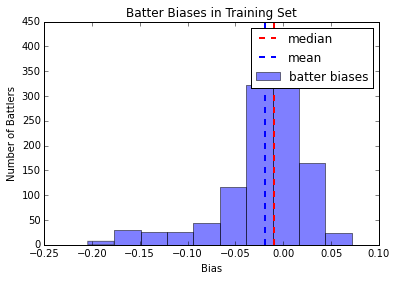

In [224]:
plt.hist(batter_biases.values(), alpha=0.5, label="batter biases");
plt.xlabel('Bias')
plt.ylabel('Number of Battlers')
plt.title('Batter Biases in Training Set')
plt.axvline(np.median(batter_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(np.mean(batter_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

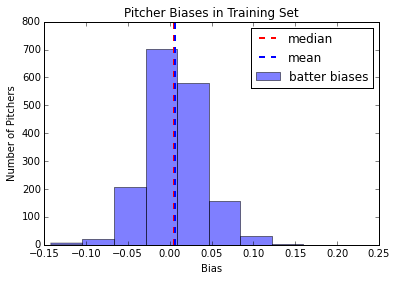

In [232]:
plt.hist(pitcher_biases.values(), alpha=0.5, label="batter biases");
plt.xlabel('Bias')
plt.ylabel('Number of Pitchers')
plt.title('Pitcher Biases in Training Set')
plt.axvline(np.median(pitcher_biases.values()), color='r', linestyle='dashed',label="median", linewidth=2)
plt.axvline(np.mean(pitcher_biases.values()), color='b', linestyle='dashed',label="mean", linewidth=2)
plt.legend();

In [233]:
train_avgs={'mean':ybar, 'users':batter_biases, 'items':item_biases}

In [234]:
train_avgs['users']

{'lopel002': -0.025865406758631915,
 'hermc001': -0.08259640355881534,
 'garca003': -0.011998482960915879,
 'mcdod002': -0.014139860102243884,
 'belta001': 0.020702867867071428,
 'tream001': -0.036104798286223067,
 'venaw001': -0.019052595728304617,
 'wilst003': 0.0012795584421618211,
 'peres002': 0.039402860699590869,
 'culbc001': 0.0080366349002949367,
 'aybae001': 0.015212041235618756,
 'bocah001': -0.030012291764163895,
 'stews002': 0.023069500801175868,
 'arrob001': -0.14146685409589277,
 'schic002': -0.10532960037288541,
 'therr001': 0.0012116555541519247,
 'vicid001': -0.0029362538413441053,
 'tejar001': -0.013159685985716096,
 'martm003': -0.04808612217352573,
 'jaraj001': -0.032600011062450696,
 'darnt001': -0.031896766495585538,
 'iguct001': -0.0090561536089249217,
 'kottg001': -0.048523827682956516,
 'cainm001': -0.15047519143758403,
 'wietm001': -0.01184192224194125,
 'niesj001': -0.17733810630052071,
 'burre001': -0.020142430329004174,
 'hoesl001': 0.040874415745321524,
 '

In [235]:
predictions={}
predictions_valid={}

In [236]:
#your code here
####

#initializing list
list_pred=[]

#for each row in test df:
for row in range(len(testdf)):
    batterid_test=testdf.iloc[row]['bID'] #get the batter
    pitcherid_test=testdf.iloc[row]['pID'] #get the restuarant id
    list_pred.append(ybar+batter_biases[batterid_test]+pitcher_biases[pitcherid_test]) #call biases and calc. pred.
    predictions["baseline"]=list_pred #add to dictionary
print len(predictions['baseline'])

#initializing list
list_pred2=[]
#for each row in validate df:
for row in range(len(validatedf)):
    batterid_val=validatedf.iloc[row]['bID'] #get the batter
    pitcherid_val=validatedf.iloc[row]['pID'] #get the restuarant id
    list_pred2.append(ybar+batter_biases[batterid_val]+pitcher_biases[pitcherid_val])#call biases and calc. pred.
    predictions_valid["baseline"]=list_pred2 #add to dictionary
print len(predictions_valid['baseline'])

1162
1743


In [237]:
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [238]:
predictions['baseline']

[0.28981662100091965,
 0.23125970446239308,
 0.23454478543014617,
 0.13920578765406544,
 0.20893018510074735,
 0.26129059562923906,
 0.39520511668430824,
 0.29684593618205113,
 0.5029015600514436,
 0.36004441719444358,
 0.30203252813316483,
 0.23036148479097379,
 0.24440638476538562,
 0.27254592205905193,
 0.16940056486732333,
 0.22080047026675639,
 0.28867077343448772,
 0.27244118382631832,
 0.24610973650249096,
 0.19190047009655842,
 0.22908683047860501,
 0.25722636777227126,
 0.22082673168041692,
 0.20867311000581112,
 0.23126280240981323,
 0.25940233970347948,
 0.23660941163047627,
 0.21238853839565081,
 0.25031443517834062,
 0.2715333672806669,
 0.2960278935867573,
 0.17788823675750565,
 0.24467282886672925,
 0.24583760733236532,
 0.22566872036891111,
 0.25512028195340375,
 0.26991974994279799,
 0.25776612826819223,
 0.51199286001180511,
 0.36913571715480509,
 0.29856590528765475,
 0.28336785210798199,
 0.24417172243828861,
 0.21194179299735835,
 0.31824198123536485,
 0.2555156938

In [241]:
def compare_results(avg_actual, avg_predicted, ylow=0, yhigh=1, model="", predicteds=False, onsame=False, axis=False):
    """
    plot predicted results against actual results. Takes 2 arguments: a
    numpy array of actual ratings and a numpy array of predicted ratings
    scatterplots the predictions, a unit slope line, line segments joining the mean,
    and a filled in area of the standard deviations."
    """
    if onsame:
        ax=onsame
    elif axis:
        ax=axis
    else:
        fig=plt.figure()
        ax=plt.gca()
    df=pd.DataFrame(dict(actual=avg_actual, predicted=avg_predicted))
    xp=[]
    yp=[]
    for k,v in df.groupby('actual'):
        xp.append(k)
        yp.append(v.predicted.mean())        
    
    cl, = ax.plot(xp,yp, 'o-', label="means for %s" % model)
    c=cl.get_color()
    sig=df.groupby('actual').predicted.std().values
    ax.fill_between(xp, yp - sig, yp + sig, 
                 color=c, alpha=0.2)
    if predicteds:
        ax.plot(df.actual, df.predicted, '.', color=c, alpha=0.1,label="predicted for %s" % model)

    if not onsame:
        ax.plot([0,1],[0,1], 'k', label="slope 1")
        ax.set_xlabel("actual")
        ax.set_ylabel("predicted")
        ax.set_ylim([ylow,yhigh])
        #ax.set_xlim([0.9, 5.1])
    ax.legend(frameon=False, loc="upper left",prop={'size':23})
    rmse=get_rmse(avg_actual, avg_predicted)
    print "RMSE for %s" % model, rmse
    rmse=3
    return ax,rmse

RMSE for baseline 0.181492381676


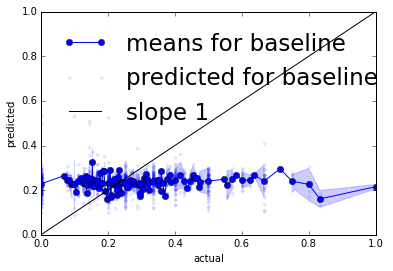

In [242]:
compare_results(testdf.AVG,predictions['baseline'], model="baseline", predicteds=True);